# **dữ liệu mẫu- tự sinh**


1.   1000 tasks
2.   100 employees
3.   5000 assignment history (mỗi assignment là một cặp task-employee với kết quả hoàn thành và điểm đánh giá)












In [41]:
pip install torch transformers sentence-transformers scikit-learn pandas numpy fastapi uvicorn

In [42]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, ndcg_score
import random

# Tạo dữ liệu mẫu
def generate_sample_data(num_tasks=1000, num_employees=50):
    # Tạo danh sách kỹ năng
    skills_pool = ['Python', 'Java', 'JavaScript', 'SQL', 'React', 'Node.js',
                  'Data Analysis', 'Machine Learning', 'Deep Learning', 'NLP',
                  'Project Management', 'UI/UX Design', 'Cloud Computing', 'DevOps']

    # Tạo tasks
    tasks = []
    for i in range(num_tasks):
        task = {
            'task_id': f'T{i:04d}',
            'title': f'Task {i}',
            'description': f'This is a detailed description for task {i} requiring specific skills',
            'required_skills': random.sample(skills_pool, k=random.randint(2, 5)),
            'difficulty_level': random.choice(['Junior', 'Mid', 'Senior']),
            'deadline_days': random.randint(1, 30),
            'expected_duration': random.randint(1, 10)
        }
        tasks.append(task)

    # Tạo employees
    employees = []
    for i in range(num_employees):
        employee = {
            'employee_id': f'E{i:03d}',
            'name': f'Employee {i}',
            'skills': random.sample(skills_pool, k=random.randint(3, 8)),
            'experience_years': random.randint(1, 15),
            'past_performance': round(random.uniform(0.5, 1.0), 2),
            'availability': round(random.uniform(0.0, 1.0), 2),
            'preferences': random.sample(skills_pool, k=random.randint(2, 4))
        }
        employees.append(employee)

    # Tạo assignment history (positive samples)
    assignments = []
    for _ in range(num_tasks * 3):  # 3 assignments per task on average
        task = random.choice(tasks)
        employee = random.choice(employees)

        # Tính điểm phù hợp cơ bản
        skill_match = len(set(task['required_skills']) & set(employee['skills'])) / len(task['required_skills'])
        performance_factor = employee['past_performance']

        # Tạo kết quả assignment dựa trên độ phù hợp
        if skill_match > 0.3 and random.random() < performance_factor:
            assignments.append({
                'task_id': task['task_id'],
                'employee_id': employee['employee_id'],
                'completion_time': random.randint(1, task['expected_duration'] + 2),
                'feedback_score': round(random.uniform(0.6, 1.0), 2),
                'success': 1
            })

    return pd.DataFrame(tasks), pd.DataFrame(employees), pd.DataFrame(assignments)

# Tạo dữ liệu
tasks_df, employees_df, assignments_df = generate_sample_data(1000, 50)
print(f"Tasks: {len(tasks_df)}")
print(f"Employees: {len(employees_df)}")
print(f"Assignments: {len(assignments_df)}")

Tasks: 1000
Employees: 50
Assignments: 1456


In [43]:
# In 10 dòng đầu của mỗi bảng
print("\n===== 🧩 Tasks (10 dòng đầu) =====")
print(tasks_df.head(10))

print("\n===== 👨‍💻 Employees (10 dòng đầu) =====")
print(employees_df.head(10))

print("\n===== 📋 Assignments (10 dòng đầu) =====")
print(assignments_df.head(10))



===== 🧩 Tasks (10 dòng đầu) =====
  task_id   title                                        description  \
0   T0000  Task 0  This is a detailed description for task 0 requ...   
1   T0001  Task 1  This is a detailed description for task 1 requ...   
2   T0002  Task 2  This is a detailed description for task 2 requ...   
3   T0003  Task 3  This is a detailed description for task 3 requ...   
4   T0004  Task 4  This is a detailed description for task 4 requ...   
5   T0005  Task 5  This is a detailed description for task 5 requ...   
6   T0006  Task 6  This is a detailed description for task 6 requ...   
7   T0007  Task 7  This is a detailed description for task 7 requ...   
8   T0008  Task 8  This is a detailed description for task 8 requ...   
9   T0009  Task 9  This is a detailed description for task 9 requ...   

                                     required_skills difficulty_level  \
0                         [NLP, React, UI/UX Design]              Mid   
1   [NLP, UI/UX Design, Pr

# **`**Tiền xử lý**`**

In [44]:
class DataPreprocessor:
    def __init__(self):
        self.skill_encoder = LabelEncoder()
        self.difficulty_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.task_embeddings = None # Add this line

    def preprocess_tasks(self, tasks_df):
        # Mã hóa difficulty level
        tasks_df['difficulty_encoded'] = self.difficulty_encoder.fit_transform(
            tasks_df['difficulty_level']
        )

        # Tạo embedding cho description
        descriptions = tasks_df['description'].tolist()
        self.task_embeddings = self.sentence_model.encode(descriptions) # Store as instance variable

        # Chuẩn hóa numerical features
        numerical_features = ['deadline_days', 'expected_duration', 'difficulty_encoded']
        tasks_df[numerical_features] = self.scaler.fit_transform(tasks_df[numerical_features])

        return tasks_df, self.task_embeddings # Return as well

    def preprocess_employees(self, employees_df):
        # Chuẩn hóa numerical features
        numerical_features = ['experience_years', 'past_performance', 'availability']
        employees_df[numerical_features] = self.scaler.fit_transform(employees_df[numerical_features])

        # Tạo skill vector (giả lập - trong thực tế cần encoding phức tạp hơn)
        all_skills = list(set([skill for skills in employees_df['skills'] for skill in skills]))
        self.skill_encoder.fit(all_skills)

        return employees_df

    def create_training_pairs(self, tasks_df, employees_df, assignments_df, task_embeddings):
        positive_pairs = []
        negative_pairs = []

        # Positive pairs từ assignment history
        for _, assignment in assignments_df.iterrows():
            task_idx = tasks_df[tasks_df['task_id'] == assignment['task_id']].index[0]
            employee_idx = employees_df[employees_df['employee_id'] == assignment['employee_id']].index[0]

            positive_pairs.append({
                'task_idx': task_idx,
                'employee_idx': employee_idx,
                'label': 1,
                'feedback_score': assignment['feedback_score']
            })

        # Negative pairs (ngẫu nhiên)
        num_negative = len(positive_pairs)
        for _ in range(num_negative):
            task_idx = random.randint(0, len(tasks_df)-1)
            employee_idx = random.randint(0, len(employees_df)-1)

            # Kiểm tra không phải positive pair
            is_positive = any(p['task_idx'] == task_idx and p['employee_idx'] == employee_idx
                            for p in positive_pairs)

            if not is_positive:
                negative_pairs.append({
                    'task_idx': task_idx,
                    'employee_idx': employee_idx,
                    'label': 0,
                    'feedback_score': 0.0
                })

        all_pairs = positive_pairs + negative_pairs
        random.shuffle(all_pairs)

        return all_pairs

# Tiền xử lý dữ liệu
preprocessor = DataPreprocessor()
tasks_processed, task_embeddings = preprocessor.preprocess_tasks(tasks_df)
employees_processed = preprocessor.preprocess_employees(employees_df)
training_pairs = preprocessor.create_training_pairs(
    tasks_processed, employees_processed, assignments_df, task_embeddings
)

print(f"Training pairs: {len(training_pairs)}")

Training pairs: 2875


# **Xây dựng model**

In [45]:
class TaskEmployeeMatchingModel(nn.Module):
    def __init__(self, task_embedding_dim=384, employee_feature_dim=3, hidden_dims=[256, 128, 64]):
        super(TaskEmployeeMatchingModel, self).__init__()

        # Task branch
        self.task_encoder = nn.Sequential(
            nn.Linear(task_embedding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128, track_running_stats=False, momentum=None), # Modified BatchNorm1d
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Employee branch
        self.employee_encoder = nn.Sequential(
            nn.Linear(employee_feature_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64, track_running_stats=False, momentum=None), # Modified BatchNorm1d
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Combined network
        combined_dim = 64 + 32  # task_encoded + employee_encoded
        layers = []
        input_dim = combined_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim, track_running_stats=False, momentum=None), # Modified BatchNorm1d
                nn.Dropout(0.2)
            ])
            input_dim = hidden_dim

        layers.append(nn.Linear(hidden_dims[-1], 1))
        layers.append(nn.Sigmoid())

        self.combined_network = nn.Sequential(*layers)

    def forward(self, task_features, employee_features):
        task_encoded = self.task_encoder(task_features)
        employee_encoded = self.employee_encoder(employee_features)

        combined = torch.cat([task_encoded, employee_encoded], dim=1)
        match_score = self.combined_network(combined)

        return match_score

class TaskEmployeeDataset(torch.utils.data.Dataset):
    def __init__(self, training_pairs, task_embeddings, employees_processed):
        self.training_pairs = training_pairs
        self.task_embeddings = task_embeddings
        self.employees_processed = employees_processed

    def __len__(self):
        return len(self.training_pairs)

    def __getitem__(self, idx):
        pair = self.training_pairs[idx]

        task_embedding = self.task_embeddings[pair['task_idx']]
        employee_features = self.employees_processed.iloc[pair['employee_idx']][
            ['experience_years', 'past_performance', 'availability']
        ].values.astype(np.float32)

        label = pair['label']

        return (torch.FloatTensor(task_embedding),
                torch.FloatTensor(employee_features),
                torch.FloatTensor([label]))

# Chuẩn bị dữ liệu training
dataset = TaskEmployeeDataset(training_pairs, task_embeddings, employees_processed)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# huấn luyện

Epoch [1/50]
Train Loss: 0.7286, Val Loss: 0.6932
Epoch [2/50]
Train Loss: 0.7023, Val Loss: 0.6922
Epoch [3/50]
Train Loss: 0.6986, Val Loss: 0.6922
Epoch [4/50]
Train Loss: 0.6958, Val Loss: 0.6931
Epoch [5/50]
Train Loss: 0.6840, Val Loss: 0.6919
Epoch [6/50]
Train Loss: 0.6795, Val Loss: 0.6959
Epoch [7/50]
Train Loss: 0.6754, Val Loss: 0.6941
Epoch [8/50]
Train Loss: 0.6714, Val Loss: 0.7025
Epoch [9/50]
Train Loss: 0.6615, Val Loss: 0.6911
Epoch [10/50]
Train Loss: 0.6594, Val Loss: 0.7082
Epoch [11/50]
Train Loss: 0.6500, Val Loss: 0.7176
Epoch [12/50]
Train Loss: 0.6585, Val Loss: 0.7167
Epoch [13/50]
Train Loss: 0.6530, Val Loss: 0.7176
Epoch [14/50]
Train Loss: 0.6385, Val Loss: 0.7314
Epoch [15/50]
Train Loss: 0.6355, Val Loss: 0.7199
Epoch [16/50]
Train Loss: 0.6231, Val Loss: 0.7267
Epoch [17/50]
Train Loss: 0.6154, Val Loss: 0.7439
Epoch [18/50]
Train Loss: 0.6103, Val Loss: 0.7495
Epoch [19/50]
Train Loss: 0.6075, Val Loss: 0.7417
Early stopping triggered!


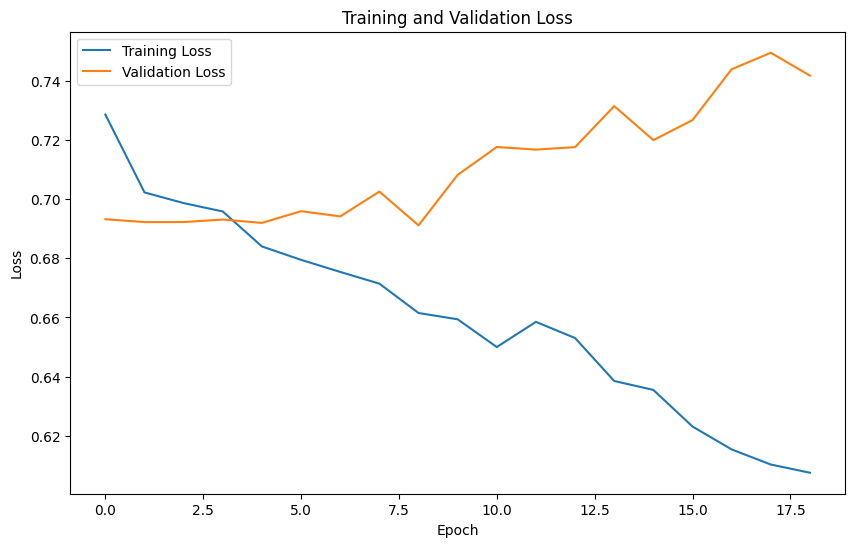

In [46]:
def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for task_feats, employee_feats, labels in train_loader:
            task_feats = task_feats.to(device)
            employee_feats = employee_feats.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(task_feats, employee_feats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for task_feats, employee_feats, labels in val_loader:
                task_feats = task_feats.to(device)
                employee_feats = employee_feats.to(device)
                labels = labels.to(device)

                outputs = model(task_feats, employee_feats)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_matching_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

        scheduler.step(avg_val_loss)

    return train_losses, val_losses

# Khởi tạo và huấn luyện mô hình
model = TaskEmployeeMatchingModel()
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=50)

# Vẽ biểu đồ loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# hệ thống gợi ý

In [67]:
class RecommendationSystem:
    def __init__(self, model, tasks_df, employees_df, preprocessor):
        self.model = model
        self.tasks_df = tasks_df
        self.employees_df = employees_df
        self.preprocessor = preprocessor
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()

    def recommend_employees_for_task(self, task_id, top_k=5):
        self.model.eval()

        task_idx = self.tasks_df[self.tasks_df['task_id'] == task_id].index[0]
        task_embedding = self.preprocessor.task_embeddings[task_idx]

        scores = []

        with torch.no_grad():
            for _, employee in self.employees_df.iterrows():
                employee_features = employee[['experience_years', 'past_performance', 'availability']].values.astype(np.float32)

                task_tensor = torch.FloatTensor(task_embedding).unsqueeze(0).to(self.device)
                employee_tensor = torch.FloatTensor(employee_features).unsqueeze(0).to(self.device)

                match_score = self.model(task_tensor, employee_tensor)
                scores.append((employee['employee_id'], match_score.item()))

        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]

    def recommend_tasks_for_employee(self, employee_id, top_k=5):
        self.model.eval()

        employee_idx = self.employees_df[self.employees_df['employee_id'] == employee_id].index[0]
        employee_features = self.employees_df.iloc[employee_idx][['experience_years', 'past_performance', 'availability']].values.astype(np.float32)

        scores = []

        with torch.no_grad():
            for task_idx, task in self.tasks_df.iterrows():
                task_embedding = self.preprocessor.task_embeddings[task_idx]

                task_tensor = torch.FloatTensor(task_embedding).unsqueeze(0).to(self.device)
                employee_tensor = torch.FloatTensor(employee_features).unsqueeze(0).to(self.device)

                match_score = self.model(task_tensor, employee_tensor)
                scores.append((task['task_id'], match_score.item()))

        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]

In [68]:
class EnhancedRecommendationSystem(RecommendationSystem):
    def __init__(self, model, tasks_df, employees_df, preprocessor):
        super().__init__(model, tasks_df, employees_df, preprocessor)

    def recommend_employees_for_new_task(self, task_description, required_skills, difficulty_level, deadline_days, expected_duration, top_k=5):
        # Tiền xử lý task mới
        task_embedding = self.preprocessor.sentence_model.encode([task_description])[0]

        # Mã hóa difficulty level (giả sử đã có encoder trong preprocessor)
        difficulty_encoded = self.preprocessor.difficulty_encoder.transform([difficulty_level])[0]

        # Chuẩn hóa các numerical features (sử dụng scaler đã fit trên training data)
        numerical_features = np.array([[deadline_days, expected_duration, difficulty_encoded]])
        numerical_features = self.preprocessor.scaler.transform(numerical_features)[0]

        # Kết hợp embedding và numerical features (trong trường hợp model của chúng ta yêu cầu cả hai)
        # Ở đây, chúng ta chỉ dùng embedding cho task, còn numerical features chưa được sử dụng trong model hiện tại.
        # Do đó, chúng ta cần điều chỉnh model để xử lý cả numerical features của task.
        # Tuy nhiên, trong model hiện tại, task chỉ được biểu diễn bằng embedding. Vì vậy, chúng ta cần phải thay đổi model.

        # Để đơn giản, chúng ta sẽ chỉ sử dụng task embedding và bỏ qua numerical features cho task trong model.
        # Nhưng trong thực tế, chúng ta nên kết hợp chúng.

        # Ở đây, chúng ta sẽ giả sử model chỉ dùng task embedding. Vì vậy, chúng ta bỏ qua numerical features của task.

        scores = []

        with torch.no_grad():
            for _, employee in self.employees_df.iterrows():
                employee_features = employee[['experience_years', 'past_performance', 'availability']].values.astype(np.float32)

                task_tensor = torch.FloatTensor(task_embedding).unsqueeze(0).to(self.device)
                employee_tensor = torch.FloatTensor(employee_features).unsqueeze(0).to(self.device)

                match_score = self.model(task_tensor, employee_tensor)

                # Tính toán các yếu tố phù hợp để giải thích
                explanation = self._compute_explanation(task_embedding, employee, required_skills, difficulty_level, deadline_days, expected_duration)

                scores.append((employee['employee_id'], match_score.item(), explanation))

        # Sắp xếp theo điểm và trả về top_k
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]

    def _compute_explanation(self, task_embedding, employee, required_skills, difficulty_level, deadline_days, expected_duration):
        # Tính toán các yếu tố phù hợp
        employee_skills = employee['skills']
        skill_overlap = len(set(required_skills) & set(employee_skills)) / len(required_skills) if required_skills else 0

        # Kinh nghiệm: so sánh với độ khó của task (giả sử độ khó có thể ánh xạ thành số năm kinh nghiệm)
        difficulty_to_experience = {'Junior': 2, 'Mid': 5, 'Senior': 8}
        required_experience = difficulty_to_experience.get(difficulty_level, 5)
        experience_diff = employee['experience_years'] - required_experience
        experience_suitability = max(0, min(1, employee['experience_years'] / required_experience)) if required_experience > 0 else 1

        # Hiệu suất trước đây
        performance = employee['past_performance']

        # Khả năng sẵn sàng
        availability = employee['availability']

        # Tạo lý do
        reasons = []
        if skill_overlap > 0.5:
            reasons.append(f"phù hợp về kỹ năng ({skill_overlap*100:.1f}%)")
        else:
            reasons.append(f"kỹ năng còn hạn chế ({skill_overlap*100:.1f}%)")

        if experience_suitability >= 1:
            reasons.append(f"kinh nghiệm dồi dào ({employee['experience_years']} năm)")
        elif experience_suitability > 0.7:
            reasons.append(f"kinh nghiệm khá ({employee['experience_years']} năm)")
        else:
            reasons.append(f"kinh nghiệm còn thiếu ({employee['experience_years']} năm)")

        if performance > 0.8:
            reasons.append("hiệu suất làm việc cao")
        elif performance > 0.6:
            reasons.append("hiệu suất làm việc khá")
        else:
            reasons.append("hiệu suất làm việc cần cải thiện")

        if availability > 0.8:
            reasons.append("khả năng sẵn sàng cao")
        elif availability > 0.5:
            reasons.append("khả năng sẵn sàng trung bình")
        else:
            reasons.append("khả năng sẵn sàng thấp")

        explanation = "; ".join(reasons)
        return explanation

**Reinforcement Learning (Online Learning)**

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Include the model definition here to ensure it's using the correct BatchNorm1d settings
class TaskEmployeeMatchingModel(nn.Module):
    def __init__(self, task_embedding_dim=384, employee_feature_dim=3, hidden_dims=[256, 128, 64]):
        super(TaskEmployeeMatchingModel, self).__init__()

        # Task branch
        self.task_encoder = nn.Sequential(
            nn.Linear(task_embedding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128, track_running_stats=False, momentum=None), # Modified BatchNorm1d
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Employee branch
        self.employee_encoder = nn.Sequential(
            nn.Linear(employee_feature_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64, track_running_stats=False, momentum=None), # Modified BatchNorm1d
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Combined network
        combined_dim = 64 + 32  # task_encoded + employee_encoded
        layers = []
        input_dim = combined_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim, track_running_stats=False, momentum=None), # Modified BatchNorm1d
                nn.Dropout(0.2)
            ])
            input_dim = hidden_dim

        layers.append(nn.Linear(hidden_dims[-1], 1))
        layers.append(nn.Sigmoid())

        self.combined_network = nn.Sequential(*layers)

    def forward(self, task_features, employee_features):
        task_encoded = self.task_encoder(task_features)
        employee_encoded = self.employee_encoder(employee_features)

        combined = torch.cat([task_encoded, employee_encoded], dim=1)
        match_score = self.combined_network(combined)

        return match_score


class ReinforcementLearningUpdater:
    def __init__(self, model, learning_rate=0.001):
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.criterion = nn.BCELoss()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def update_with_feedback(self, task_embedding, employee_features, feedback_score, success):
        """
        Cập nhật mô hình dựa trên feedback.
        """
        current_mode = self.model.training

        task_tensor = torch.FloatTensor(task_embedding).unsqueeze(0).to(self.device)
        employee_tensor = torch.FloatTensor(employee_features).unsqueeze(0).to(self.device)

        self.optimizer.zero_grad()

        # 1. Tạm thời đặt mô hình sang chế độ EVAL
        # Điều này cho phép BatchNorm1d xử lý Batch Size = 1 mà không bị lỗi.
        self.model.eval()

        # Dự đoán hiện tại (Forward pass)
        current_pred = self.model(task_tensor, employee_tensor)

        # 2. Đặt mô hình lại về chế độ TRAIN
        # Điều này là BẮT BUỘC để gradient được tính toán và trọng số được cập nhật.
        self.model.train()

        # Target dựa trên feedback
        if success:
            target = torch.FloatTensor([[feedback_score]]).to(self.device)
        else:
            target = torch.FloatTensor([[0.0]]).to(self.device)

        # Tính toán loss và backpropagate
        loss = self.criterion(current_pred, target)
        loss.backward()
        self.optimizer.step()

        # 3. Khôi phục chế độ ban đầu (dù thường là train)
        self.model.train(current_mode)

        return loss.item()

**Triển khai API**

In [53]:
!pip install fastapi uvicorn pyngrok nest_asyncio


/usr/local/lib/python3.12/dist-packages/importlib_metadata/_collections.py:22: RuntimeWarning: coroutine 'Server.serve' was never awaited
  return getattr(self, '_frozen', super().__missing__)(key)


In [70]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from pyngrok import ngrok
import nest_asyncio
import torch, numpy as np, pandas as pd
from uvicorn import Config, Server
import threading
import joblib
from typing import List, Optional

# ========== SỬ DỤNG MÔ HÌNH THỰC TẾ ==========
print("🔄 Đang tải mô hình thực tế...")

# Tải mô hình đã huấn luyện
try:
    model = TaskEmployeeMatchingModel()
    model.load_state_dict(torch.load('best_matching_model.pth', map_location=torch.device('cpu')))
    model.eval()
    print("✅ Đã tải mô hình huấn luyện")
except:
    print("⚠️ Không tìm thấy mô hình đã huấn luyện, sử dụng mô hình mới")
    model = TaskEmployeeMatchingModel()

# Sử dụng dữ liệu thực tế từ quá trình huấn luyện
print("📊 Đang tải dữ liệu thực tế...")

class RealRecommendationSystem:
    def __init__(self, model, tasks_df, employees_df, preprocessor):
        self.model = model
        self.tasks_df = tasks_df
        self.employees_df = employees_df
        self.preprocessor = preprocessor
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()

    def recommend_employees_for_task(self, task_id, top_k=5):
        try:
            self.model.eval()
            task_idx = self.tasks_df[self.tasks_df['task_id'] == task_id].index[0]
            task_embedding = self.preprocessor.task_embeddings[task_idx]

            scores = []

            with torch.no_grad():
                for _, employee in self.employees_df.iterrows():
                    employee_features = employee[['experience_years', 'past_performance', 'availability']].values.astype(np.float32)

                    task_tensor = torch.FloatTensor(task_embedding).unsqueeze(0).to(self.device)
                    employee_tensor = torch.FloatTensor(employee_features).unsqueeze(0).to(self.device)

                    match_score = self.model(task_tensor, employee_tensor)
                    scores.append((employee['employee_id'], match_score.item()))

            scores.sort(key=lambda x: x[1], reverse=True)
            return scores[:top_k]
        except Exception as e:
            print(f"❌ Lỗi trong recommend_employees_for_task: {e}")
            # Fallback: trả về kết quả ngẫu nhiên nếu có lỗi
            return [(row.employee_id, np.random.rand()) for _, row in self.employees_df.iterrows()][:top_k]

    def recommend_tasks_for_employee(self, employee_id, top_k=5):
        try:
            self.model.eval()
            employee_idx = self.employees_df[self.employees_df['employee_id'] == employee_id].index[0]
            employee_features = self.employees_df.iloc[employee_idx][['experience_years', 'past_performance', 'availability']].values.astype(np.float32)

            scores = []

            with torch.no_grad():
                for task_idx, task in self.tasks_df.iterrows():
                    task_embedding = self.preprocessor.task_embeddings[task_idx]

                    task_tensor = torch.FloatTensor(task_embedding).unsqueeze(0).to(self.device)
                    employee_tensor = torch.FloatTensor(employee_features).unsqueeze(0).to(self.device)

                    match_score = self.model(task_tensor, employee_tensor)
                    scores.append((task['task_id'], match_score.item()))

            scores.sort(key=lambda x: x[1], reverse=True)
            return scores[:top_k]
        except Exception as e:
            print(f"❌ Lỗi trong recommend_tasks_for_employee: {e}")
            # Fallback
            return [(row.task_id, np.random.rand()) for _, row in self.tasks_df.iterrows()][:top_k]

class RealReinforcementLearningUpdater:
    def __init__(self, model, learning_rate=0.001):
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.criterion = torch.nn.BCELoss()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def update_with_feedback(self, task_embedding, employee_features, feedback_score, success):
        try:
            task_tensor = torch.FloatTensor(task_embedding).unsqueeze(0).to(self.device)
            employee_tensor = torch.FloatTensor(employee_features).unsqueeze(0).to(self.device)

            self.optimizer.zero_grad()

            # Tạm thời sang eval mode để xử lý batch size = 1
            self.model.eval()
            current_pred = self.model(task_tensor, employee_tensor)
            self.model.train()

            # Target dựa trên feedback
            if success:
                target = torch.FloatTensor([[feedback_score]]).to(self.device)
            else:
                target = torch.FloatTensor([[0.0]]).to(self.device)

            loss = self.criterion(current_pred, target)
            loss.backward()
            self.optimizer.step()

            return loss.item()
        except Exception as e:
            print(f"❌ Lỗi trong update_with_feedback: {e}")
            return 0.0  # Trả về loss = 0 nếu có lỗi

# ========== FASTAPI ==========
app = FastAPI(title="Hệ thống gợi ý Task-Employee", version="1.0.0")

class RecommendationRequest(BaseModel):
    task_id: Optional[str] = None
    employee_id: Optional[str] = None
    top_k: int = 5

class FeedbackRequest(BaseModel):
    task_id: str
    employee_id: str
    feedback_score: float
    success: bool

class NewTaskRequest(BaseModel):
    description: str
    required_skills: List[str]
    difficulty_level: str
    deadline_days: int
    expected_duration: int
    top_k: int = 5

@app.on_event("startup")
async def startup_event():
    global recommendation_system, rl_updater
    print("🚀 Khởi động hệ thống gợi ý...")

    # Khởi tạo hệ thống với dữ liệu thực tế
    recommendation_system = RealRecommendationSystem(model, tasks_processed, employees_processed, preprocessor)
    rl_updater = RealReinforcementLearningUpdater(model)

    print(f"✅ Hệ thống đã sẵn sàng:")
    print(f"   - Số task: {len(tasks_processed)}")
    print(f"   - Số employee: {len(employees_processed)}")
    print(f"   - Model: {type(model).__name__}")

@app.get("/")
async def root():
    return {
        "message": "Hệ thống gợi ý Task-Employee API",
        "status": "running",
        "version": "1.0.0",
        "endpoints": ["/recommend", "/feedback", "/tasks", "/employees"]
    }

@app.get("/tasks")
async def get_all_tasks():
    """Lấy danh sách tất cả tasks"""
    tasks = tasks_df[['task_id', 'title', 'difficulty_level', 'required_skills']].to_dict('records')
    return {"tasks": tasks, "total_tasks": len(tasks)}

@app.get("/employees")
async def get_all_employees():
    """Lấy danh sách tất cả employees"""
    employees = employees_df[['employee_id', 'name', 'experience_years', 'skills']].to_dict('records')
    return {"employees": employees, "total_employees": len(employees)}

@app.post("/recommend")
async def get_recommendations(request: RecommendationRequest):
    try:
        if request.task_id:
            # Kiểm tra task_id có tồn tại không
            if request.task_id not in tasks_processed['task_id'].values:
                raise HTTPException(status_code=404, detail=f"Task {request.task_id} không tồn tại")

            recs = recommendation_system.recommend_employees_for_task(request.task_id, request.top_k)
            return {
                "task_id": request.task_id,
                "recommendations": [
                    {
                        "employee_id": emp_id,
                        "match_score": round(score, 4),
                        "match_percentage": f"{score*100:.1f}%"
                    } for emp_id, score in recs
                ],
                "total_recommendations": len(recs)
            }
        elif request.employee_id:
            # Kiểm tra employee_id có tồn tại không
            if request.employee_id not in employees_processed['employee_id'].values:
                raise HTTPException(status_code=404, detail=f"Employee {request.employee_id} không tồn tại")

            recs = recommendation_system.recommend_tasks_for_employee(request.employee_id, request.top_k)
            return {
                "employee_id": request.employee_id,
                "recommendations": [
                    {
                        "task_id": task_id,
                        "match_score": round(score, 4),
                        "match_percentage": f"{score*100:.1f}%"
                    } for task_id, score in recs
                ],
                "total_recommendations": len(recs)
            }
        else:
            raise HTTPException(status_code=400, detail="Phải cung cấp task_id hoặc employee_id")
    except HTTPException:
        raise
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Lỗi khi tạo gợi ý: {str(e)}")

@app.post("/feedback")
async def submit_feedback(request: FeedbackRequest):
    try:
        # Kiểm tra task_id và employee_id có tồn tại không
        if request.task_id not in tasks_processed['task_id'].values:
            raise HTTPException(status_code=404, detail=f"Task {request.task_id} không tồn tại")
        if request.employee_id not in employees_processed['employee_id'].values:
            raise HTTPException(status_code=404, detail=f"Employee {request.employee_id} không tồn tại")

        # Tìm indices
        task_idx = tasks_processed[tasks_processed['task_id'] == request.task_id].index[0]
        employee_idx = employees_processed[employees_processed['employee_id'] == request.employee_id].index[0]

        # Lấy features
        task_embedding = preprocessor.task_embeddings[task_idx]
        employee_features = employees_processed.iloc[employee_idx][
            ['experience_years', 'past_performance', 'availability']
        ].values.astype(np.float32)

        # Cập nhật model
        loss = rl_updater.update_with_feedback(
            task_embedding,
            employee_features,
            request.feedback_score,
            request.success
        )

        return {
            "status": "success",
            "message": "Đã cập nhật model với feedback",
            "loss": round(loss, 6),
            "details": {
                "task_id": request.task_id,
                "employee_id": request.employee_id,
                "feedback_score": request.feedback_score,
                "success": request.success
            }
        }
    except HTTPException:
        raise
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Lỗi khi xử lý feedback: {str(e)}")

@app.post("/recommend/new-task")
async def recommend_for_new_task(request: NewTaskRequest):
    try:
        # Sử dụng EnhancedRecommendationSystem nếu có
        if 'EnhancedRecommendationSystem' in globals():
            enhanced_system = EnhancedRecommendationSystem(model, tasks_processed, employees_processed, preprocessor)
            recommendations = enhanced_system.recommend_employees_for_new_task(
                task_description=request.description,
                required_skills=request.required_skills,
                difficulty_level=request.difficulty_level,
                deadline_days=request.deadline_days,
                expected_duration=request.expected_duration,
                top_k=request.top_k
            )

            return {
                "recommendations": [
                    {
                        "employee_id": emp_id,
                        "match_score": round(score, 4),
                        "match_percentage": f"{score*100:.1f}%",
                        "explanation": explanation
                    }
                    for emp_id, score, explanation in recommendations
                ],
                "task_details": {
                    "description": request.description,
                    "required_skills": request.required_skills,
                    "difficulty_level": request.difficulty_level,
                    "deadline_days": request.deadline_days,
                    "expected_duration": request.expected_duration
                }
            }
        else:
            # Fallback: sử dụng hệ thống cơ bản
            recs = recommendation_system.recommend_employees_for_task(tasks_processed.iloc[0]['task_id'], request.top_k)
            return {
                "recommendations": [
                    {
                        "employee_id": emp_id,
                        "match_score": round(score, 4),
                        "match_percentage": f"{score*100:.1f}%",
                        "explanation": "Gợi ý dựa trên task mẫu (fallback)"
                    }
                    for emp_id, score in recs
                ],
                "note": "Sử dụng chế độ fallback cho task mới"
            }
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Lỗi khi xử lý task mới: {str(e)}")

# ========== CHẠY TRONG GOOGLE COLAB ==========
print("🌐 Đang khởi động server...")

# Cấu hình ngrok
try:
    ngrok.set_auth_token("34xcM1tRJqvJcIPVaK5temE949g_5FXFfcyYimcfmeXZnpgR")
    nest_asyncio.apply()

    # Tạo public URL
    public_url = ngrok.connect(8000)
    print(f"🌍 Public URL: {public_url.public_url}")
    print(f"📚 API Docs: {public_url.public_url}/docs")
except Exception as e:
    print(f"⚠️ Lỗi khi kết nối ngrok: {e}")
    print("🚫 Server sẽ chạy ở chế độ local")

# Chạy uvicorn bằng thread
def run_server():
    try:
        config = Config(app=app, host="0.0.0.0", port=8000, log_level="info")
        server = Server(config=config)
        server.run()
    except Exception as e:
        print(f"❌ Lỗi khi chạy server: {e}")

thread = threading.Thread(target=run_server, daemon=True)
thread.start()

print("✅ Server đang chạy!")
print("🔧 Các endpoint có sẵn:")
print("   - GET  / : Trang chủ")
print("   - GET  /tasks : Danh sách tasks")
print("   - GET  /employees : Danh sách employees")
print("   - POST /recommend : Gợi ý task/employee")
print("   - POST /feedback : Gửi feedback")
print("   - POST /recommend/new-task : Gợi ý cho task mới")

🔄 Đang tải mô hình thực tế...
✅ Đã tải mô hình huấn luyện
📊 Đang tải dữ liệu thực tế...
🌐 Đang khởi động server...


/tmp/ipython-input-3058761238.py:144: DeprecationWarning: 
        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        
  @app.on_event("startup")


🌍 Public URL: https://applicably-cotemporaneous-frieda.ngrok-free.dev
📚 API Docs: https://applicably-cotemporaneous-frieda.ngrok-free.dev/docs
✅ Server đang chạy!
🔧 Các endpoint có sẵn:
   - GET  / : Trang chủ
   - GET  /tasks : Danh sách tasks
   - GET  /employees : Danh sách employees
   - POST /recommend : Gợi ý task/employee
   - POST /feedback : Gửi feedback
   - POST /recommend/new-task : Gợi ý cho task mới


**Đánh giá mô hình**

In [71]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score

def evaluate_model(model, val_loader):
    print("🔍 Đánh giá toàn diện mô hình...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for task_feats, employee_feats, labels in val_loader:
            task_feats = task_feats.to(device)
            employee_feats = employee_feats.to(device)

            outputs = model(task_feats, employee_feats)

            all_probabilities.extend(outputs.cpu().numpy())
            all_predictions.extend((outputs > 0.5).int().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_predictions = np.array(all_predictions).flatten()
    all_labels = np.array(all_labels).flatten()
    all_probabilities = np.array(all_probabilities).flatten()

    # Tính các metrics
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)

    # AUC-ROC (nếu có cả positive và negative samples)
    if len(np.unique(all_labels)) > 1:
        auc_roc = roc_auc_score(all_labels, all_probabilities)
    else:
        auc_roc = float('nan')

    print("\\n" + "="*50)
    print("📊 KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH")
    print("="*50)
    print(f"Accuracy:    {accuracy:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"AUC-ROC:     {auc_roc:.4f}")
    print(f"Total samples: {len(all_labels)}")
    print(f"Positive samples: {np.sum(all_labels)}")
    print(f"Negative samples: {len(all_labels) - np.sum(all_labels)}")
    print("="*50)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_roc
    }

# Chạy đánh giá
results = evaluate_model(model, val_loader)


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-10' coro=<Server.serve() done, defined at /usr/local/lib/python3.12/dist-packages/uvicorn/server.py:69> exception=SystemExit(1)>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/server.py", line 164, in startup
    server = await loop.create_server(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/asyncio/base_events.py", line 1584, in create_server
    raise OSError(err.errno, msg) from None
OSError: [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): [errno 98] address already in use

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipython-input-3058761238.py", li

🔍 Đánh giá toàn diện mô hình...
\n==================================================
📊 KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH
Accuracy:    0.5739
Precision:   0.5700
Recall:      0.5839
F1-Score:    0.5769
AUC-ROC:     0.5875
Total samples: 575
Positive samples: 286.0
Negative samples: 289.0
